Inspired by https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html (preprocessing, hyperparameter optimization) and using bayesian-optimization for hyperparameter optimization. Pipelines are heavily used and saved using dill instead of pickle.

In [1]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')

In [2]:
# Preprocessing: Standardization, PCA
# Models: KMeans (Based on other Papers)
# Metrics: R2, RMSE, MAE

In [3]:
# Define the metric and load the data
from sklearn.metrics import make_scorer, mean_squared_error
from ltm.features import load_raster, drop_nan_rows
from ltm.models import area2mixture_scorer

# Define the metric for base area labels
rmse_scorer = make_scorer(mean_squared_error, squared=False)
rmse_scorer = area2mixture_scorer(rmse_scorer)

# Load the data
X = load_raster("../data/processed/composites_X.tif")
y = load_raster("../data/processed/y_area.tif")

# Remove NaN columns from X and drop rows with NaN in y
X = X.dropna(axis=1)
X, y = drop_nan_rows(X, y)

In [4]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

category_data = {}

def log_point(x, y, category):
    global category_data

    if category not in category_data.keys():
        category_data[category] = (np.array([x]), np.array([y]))
    else:
        xs, ys = category_data[category]
        xs = np.hstack((xs, x))
        ys = np.hstack((ys, y))

        args = np.argsort(xs)
        xs = xs[args]
        ys = ys[args]

        category_data[category] = (xs, ys)

def plot():
    global category_data

    if max(len(x) for x, y in category_data.values()) < 2:
        return
    
    clear_output(wait=True)  # Clear the output to update the plot

    for category in category_data.keys():
        x, y = category_data[category]
        plt.plot(x.astype(int), y, label=category)

    plt.ylim(ymin=0)
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")
    plt.title("Scatter Plot with Updated Point")
    plt.legend()
    plt.show()

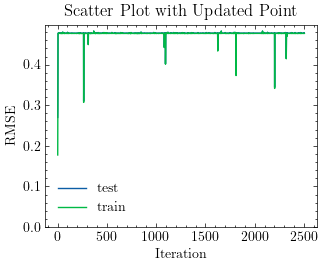

| 2502      | -0.4777   | 782.4     | 0.7971    | 122.7     | 0.6318    | 0.244     | 0.1226    | 815.8     | 940.5     |


In [5]:
# Search best Random Forest hyperparameters
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from bayes_opt import BayesianOptimization, UtilityFunction

counter = 2  # number of probe points

def black_box_function(
    n_components: int,
    n_estimators: int,
    max_depth: int,
    min_samples_split: float,
    min_samples_leaf: float,
    max_features: float,
    max_leaf_nodes: int,
    min_impurity_decrease: float,
):
    # Floor to int
    n_components = int(n_components)
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    max_leaf_nodes = int(max_leaf_nodes)

    # Use the loaded dataset
    global X
    global y

    # Define pipeline elements
    scaler = StandardScaler()
    pca = PCA(n_components=n_components, random_state=42)
    regressor = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes,
        min_impurity_decrease=min_impurity_decrease,
        n_jobs=-1,
        random_state=42)

    # Create pipeline object
    pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("regressor", regressor)])

    # Cross validate the pipeline
    cv_results = cross_validate(pipe, X, y, cv=5, scoring=rmse_scorer, return_train_score=True, n_jobs=-1)
    score = cv_results["test_score"].mean()
    train_score = cv_results["train_score"].mean()

    # Plot the test and train score
    global counter
    log_point(counter, score, "test")
    log_point(counter, train_score, "train")
    plot()
    counter += 1

    # Negate score as bayes_opt maximizes
    score *= -1

    return score

# Bounded region of parameter space
pbounds = {
    "n_components": (1, min(len(X), len(X.columns)) * 0.8 + 0.999),
    "n_estimators": (1, 1000),
    "max_depth": (1, 1000),
    "min_samples_split": (0.001, 0.999),
    "min_samples_leaf": (0.001, 0.999),
    "max_features": (0.001, 1),
    "max_leaf_nodes": (2, 1000),
    "min_impurity_decrease": (0, 1),
}

# Create optimizer
optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    random_state=42,
)

# Probe good points
optimizer.probe(
    params={
        "n_components": 30,
        "n_estimators": 100,
        "max_depth": 1000,
        "min_samples_split": 0.001,
        "min_samples_leaf": 0.001,
        "max_features": 1,
        "max_leaf_nodes": 1000,
        "min_impurity_decrease": 0,
    },
    lazy=True,
)

optimizer.probe(
    params={
        "n_components": 10,
        "n_estimators": 50,
        "max_depth": 100,
        "min_samples_split": 0.01,
        "min_samples_leaf": 0.01,
        "max_features": 0.9,
        "max_leaf_nodes": 200,
        "min_impurity_decrease": 0.001,
    },
    lazy=True,
)

# Find optimum
optimizer.maximize(
    init_points=0,
    n_iter=2500,
)

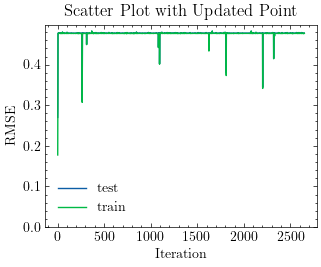

| 2648      | -0.4777   | 708.2     | 0.9072    | 144.1     | 0.908     | 0.7419    | 0.179     | 303.9     | 965.7     |


In [9]:
# Find optimum
try:
    while True:
        utility = UtilityFunction("ucb", kappa_decay=0.5)
        optimizer.maximize(
            init_points=0,
            n_iter=100,
            acquisition_function=utility,
        )
except KeyboardInterrupt:
    pass

In [10]:
import pandas as pd

df = pd.DataFrame([dict({"RMSE": -iteration["target"]}, **iteration["params"])
              for iteration in optimizer.res])

df = df.sort_values("RMSE")

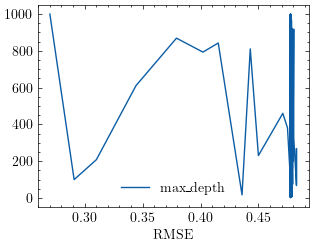

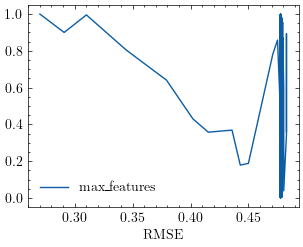

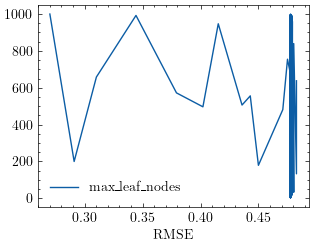

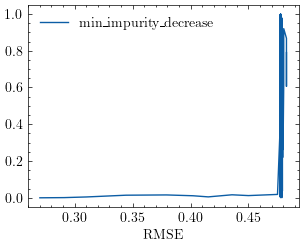

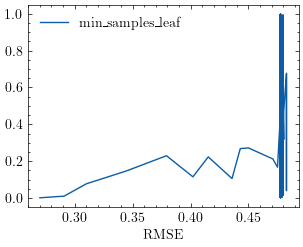

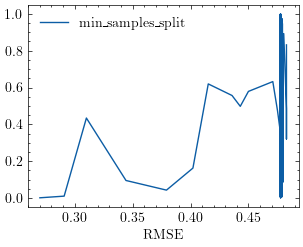

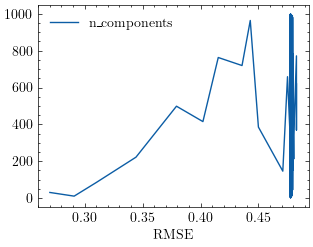

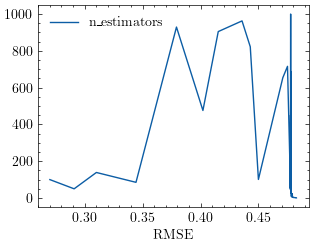

In [17]:
columns = [column for column in df.columns if column != "RMSE"]

for column in columns:
    df.plot(x="RMSE", y=column)
    plt.show()

In [49]:
def round_down(n):
    if n == 0:
        return 0
    
    shift = np.floor(np.log10(n))
    n = n / 10 ** shift
    n = np.floor(n)
    n = n * 10 ** shift
    
    return n

def round_up(n):
    if n == 0:
        return 0
    
    shift = np.floor(np.log10(n))
    n = n / 10 ** shift
    n = np.ceil(n)
    n = n * 10 ** shift
    
    return n

lower_bounds = dict(df[df["RMSE"] < 0.45][columns].min())
upper_bounds = dict(df[df["RMSE"] < 0.45][columns].max())
combined_bounds = {key: (round_down(lower_bounds[key]), round_up(upper_bounds[key])) for key in lower_bounds.keys()}
combined_bounds

{'max_depth': (10.0, 1000.0),
 'max_features': (0.1, 1.0),
 'max_leaf_nodes': (100.0, 1000.0),
 'min_impurity_decrease': (0, 0.02),
 'min_samples_leaf': (0.001, 0.30000000000000004),
 'min_samples_split': (0.001, 0.7000000000000001),
 'n_components': (10.0, 1000.0),
 'n_estimators': (50.0, 1000.0)}